# Tutorial 2. Trainable task
### **NOTE!** This guide is written for NNDT v0.0.0rc. We are working on API improvements every day.

This notebook includes training of a neural network model, so the use of GPU environement is highly advised.

A trainable task is a ready-to-use implementation of a neural network with loss. Each trainable task has two internal classes: DATA and FUNC. The first includes all data that is necessary for training. The second one includes all the functions for data processing. FUNC also includes `main_loss` for the training.

The following code installs the NNDT package and downloads minimal data for experiments.

In [1]:
# Install NNDT
!pip install git+https://github.com/KonstantinUshenin/nndt.git@v0.0.1rc
# Download sample data
!wget https://github.com/KonstantinUshenin/nndt/raw/main/tests/acdc_for_test.7z
!7z x acdc_for_test.7z

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/KonstantinUshenin/nndt.git (to revision v0.0.1rc) to /tmp/pip-req-build-nb4ubgoa
  Running command git clone -q https://github.com/KonstantinUshenin/nndt.git /tmp/pip-req-build-nb4ubgoa
  Running command git checkout -b v0.0.1rc --track origin/v0.0.1rc
  Switched to a new branch 'v0.0.1rc'
  Branch 'v0.0.1rc' set up to track remote branch 'v0.0.1rc' from 'origin'.
     |████████████████████████████████| 41 kB 533 kB/s 
     |████████████████████████████████| 342 kB 28.7 MB/s 
     |████████████████████████████████| 145 kB 70.0 MB/s 
     |████████████████████████████████| 88.3 MB 123 kB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
  Created wheel for NNDT: filename=NNDT-0.0.0-py3-none-any.whl size=21854 sha256=1b8478f809476f844892dd1eed92ae878ec20c4befe9e583069270145bd197eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ifn3fko/wheels/81/b4/6

Constants.

In [2]:
LEARNING_RATE = 0.006
EPOCHS = 6001
SHAPE = (64, 64, 64)
FLAT_SHAPE = SHAPE[0] * SHAPE[1] * SHAPE[2]
EXP_NAME = 'sdf_multiple_files'
LOG_FOLDER = f'./{EXP_NAME}/'
LEVEL_SHIFT = 0.03

In [3]:
import jax
import jax.numpy as jnp
import optax

In [4]:
from nndt.trainable_task import *
from nndt.space.loaders import *
from nndt.vizualize import *

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


This is simple data loader from the previous tutorial.

In [5]:
patient_name_list = ['patient009']
print(patient_name_list)
mesh_list = [f"./acdc_for_test/{p}/colored.obj" for p in patient_name_list]
sdt_list = [f"./acdc_for_test/{p}/sdf.npy" for p in patient_name_list]

space = load_data(patient_name_list, mesh_list, sdt_list)
preload_all_possible(space)
print(space.explore())

['patient009']
Space("main", bbox="((-0.95, -0.91, -0.91), (0.95, 0.91, 0.91))")
├── Group("default", bbox="((-0.95, -0.91, -0.91), (0.95, 0.91, 0.91))")
│   ├── Object("patient009", bbox="((-0.95, -0.91, -0.91), (0.95, 0.91, 0.91))")
│   │   ├── MeshSource("mesh", filename="colored.obj")
│   │   │   └── MeshRepr("repr", bbox="((-0.95, -0.91, -0.91), (0.95, 0.91, 0.91))")
│   │   │       ├── index2xyz(ns_index[1]) -> ns_xyz[3]
│   │   │       ├── sampling_eachN(count=N, step=1, shift=0) -> (ns_index[N], ns_xyz[N])
│   │   │       ├── save_mesh(filepath, dict)
│   │   │       ├── PointColorRepr("point_color")
│   │   │       ├── sampling_grid(spacing=(D,H,W)) -> xyz[D,H,W,3]
│   │   │       ├── sampling_uniform(N) -> xyz[N,3]
│   │   │       └── sampling_grid_with_shackle(N) -> xyz[N,3]
│   │   ├── SDTSource("sdt", filename="sdf.npy")
│   │   │   └── SDTRepr("repr", bbox="((-0.94, -0.90, -0.90), (0.94, 0.90, 0.90))")
│   │   │       ├── xyz2sdt(ns_xyz[...,3]) -> ns_sdt[...,1]
│   │   │ 

Now we create a uniform grid in the boundary box of the object. Then, we convert the coordinates to signed distance function values (SDF).

In [6]:
xyz = space[f'sampling_grid'](spacing=SHAPE)
xyz_flat = xyz.reshape((-1, 3))
sdf_flat = jnp.squeeze(space[f'default/patient009/sdt/repr/xyz2sdt'](xyz_flat))

DATA is a named tuple with all required data. X,Y,Z coordinates. SDF value. T and P are not used here but should be filled by default values.

In [7]:
DATA = ApproximateSDF.DATA(X=xyz_flat[:, 0],
                            Y=xyz_flat[:, 1],
                            Z=xyz_flat[:, 2],
                            T=jnp.zeros(sdf_flat.shape[0]),
                            P=jnp.ones((sdf_flat.shape[0], 1)),
                            SDF=sdf_flat)

print(DATA)

DATA(X=DeviceArray([-0.94676656, -0.94676656, -0.94676656, ...,  0.94676656,
              0.94676656,  0.94676656], dtype=float32), Y=DeviceArray([-0.9056295, -0.9056295, -0.9056295, ...,  0.9056295,
              0.9056295,  0.9056295], dtype=float32), Z=DeviceArray([-0.9056295 , -0.87687933, -0.8481293 , ...,  0.8481294 ,
              0.8768795 ,  0.9056295 ], dtype=float32), T=DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float32), P=DeviceArray([[1.],
             [1.],
             [1.],
             ...,
             [1.],
             [1.],
             [1.]], dtype=float32), SDF=DeviceArray([0.59430635, 0.58855754, 0.5789646 , ..., 0.83761567,
             0.83761567, 0.83761567], dtype=float32))


Now we initialize the neural network and optimizer.

In [8]:
task = ApproximateSDF(batch_size=FLAT_SHAPE, model_number=1)
rng = jax.random.PRNGKey(42)
params, F = task.init_and_functions(rng)
D_INIT = task.init_data()

opt = optax.adam(LEARNING_RATE)
opt_state = opt.init(params)

/usr/local/lib/python3.7/dist-packages/haiku/_src/stateful.py:771: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  if not jax.tree_leaves(in_axes):
/usr/local/lib/python3.7/dist-packages/haiku/_src/multi_transform.py:161: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  return Box(jax.tree_structure(apply_fns))
/usr/local/lib/python3.7/dist-packages/haiku/_src/multi_transform.py:329: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/usr/local/lib/python3.7/d

Here we define our train steps

In [9]:
@jax.jit
def train_step(params, rng, opt_state):

    loss, grads = jax.value_and_grad(F.vec_main_loss)(params, rng, *tuple(DATA))
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return loss, params, rng, opt_state

And now we perform a basic training loop with saving intermediary results.

[E:0,T:0.0] 



/usr/local/lib/python3.7/dist-packages/haiku/_src/multi_transform.py:147: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  return jax.tree_leaves(f()[1])[i](*args, **kwargs)


[E:1000,T:42.9] loss=0.0005642010946758091, 

[E:2000,T:78.6] loss=0.00030994214466772974, 

[E:3000,T:116.1] loss=0.0001567269500810653, 

[E:4000,T:155.7] loss=0.0009517514845356345, 

[E:5000,T:193.4] loss=0.0001956173509825021, 

[E:6000,T:232.8] loss=9.923346806317568e-05, 



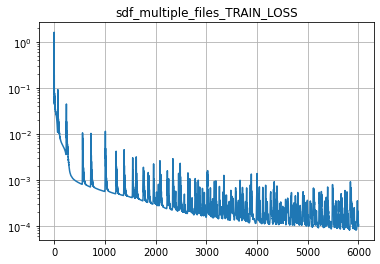

In [10]:
max_loss = 99999
viz = BasicVizualization(LOG_FOLDER, EXP_NAME, print_on_each_epoch=1000)
for epoch in viz.iter(EPOCHS):

    loss, params, rng, opt_state = train_step(params, rng, opt_state)

    viz.record({"loss": float(loss)})

    if viz.is_print_on_epoch(epoch):
        predict = F.vec_sdf(params, rng,
                        DATA.X, DATA.Y, DATA.Z,
                        DATA.T, DATA.P)

        viz.sdf_to_obj("exact", DATA.SDF.reshape(SHAPE))
        viz.sdf_to_obj("predict", predict.reshape(SHAPE), level=LEVEL_SHIFT)

        viz.draw_loss("TRAIN_LOSS", viz._records["loss"])

        if loss < max_loss:
            viz.save_state('sdf_model', params)
            max_loss = loss

    rng, subkey = jax.random.split(rng)

Loss, .obj files, and model checkpoint can be found in created folder 'sdf_multiple_files'

The following code show the training loss.

(-0.5, 431.5, 287.5, -0.5)

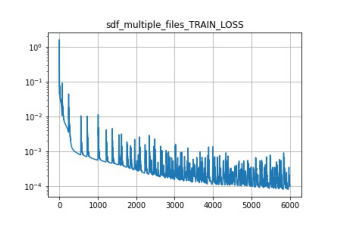

In [11]:
import matplotlib.pylab as plt

img = plt.imread(f'./{EXP_NAME}/TRAIN_LOSS.jpg')
plt.imshow(img)
plt.axis('off')

Paraview or pyvista can vizualize `predict.obj` and `exact.obj`. The image below shows the comparison of two models. The red color represents the predicted model, and the white color shows the expected one. The visualization of both is obtained with cube marching.

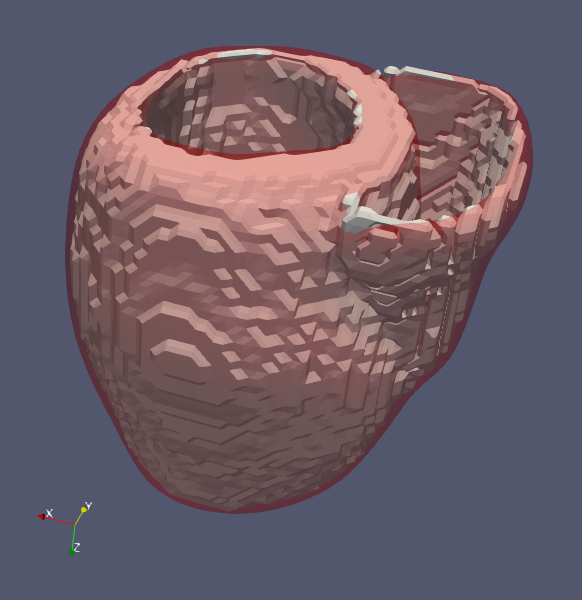